In [1]:
#imports
%matplotlib notebook
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.cm as cm
import matplotlib.colors as colors

from functions.utils import n_params, vector_to_state_dict, state_dict_to_vector, get_param_state
from functions.my_optimizers import GDMethod,MomentumMethod, Adagrad, RMSProp,LinearLrUpdate, StepLrUpdate, ExpLrUpdate, CostLrUpdate
from functions.mod_adam import Adam

#generating approximately linear data from python func
from lin_reg_data import getLinRegDatasets

In [2]:
num_epochs = 5
batch_size = 32

lr = 0.005
betas = (0.9, 0.999)

In [3]:
!nvidia-smi

Mon Sep 20 18:26:02 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 470.42.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA TITAN V      Off  | 00000000:03:00.0 Off |                  N/A |
| 34%   48C    P2   105W / 250W |   7448MiB / 12066MiB |     39%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   

In [4]:
device = 'cuda:2'

<IPython.core.display.Javascript object>


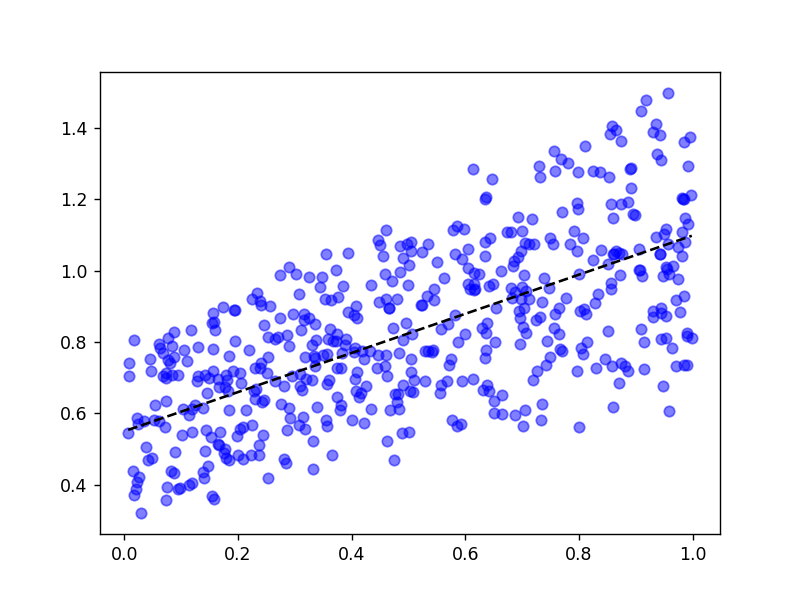

In [5]:
#setting data parameters
num_train = 10000
num_test = 500
m_var = 0.25
b_var = 0.25

#setting random number seed for data generation
np.random.seed(seed=0)

train_set, test_set, m, b = getLinRegDatasets(num_train, num_test,
                                            x_dim=1, y_dim=1,
                                            m_var=m_var, b_var=b_var)

#uses pytorch dataloader to make it easier to train and test model
train_data = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_data = DataLoader(test_set, batch_size=batch_size, shuffle=True)

x_train = np.array([tensor_tuple[0].detach().numpy() for tensor_tuple in train_set])
y_train = np.array([tensor_tuple[1].detach().numpy()[0] for tensor_tuple in train_set])
x_test = np.array([tensor_tuple[0].detach().numpy() for tensor_tuple in test_set])
y_test = np.array([tensor_tuple[1].detach().numpy()[0] for tensor_tuple in test_set])

x = x_test.reshape(num_test)
y = y_test.reshape(num_test)
plt.figure()
plt.scatter(x, y, c='b', alpha=0.5)
axis = np.linspace(min(x),max(x),100)
plt.plot(axis, [m[0,0]*val + b[0] for val in axis], 'k--')

In [6]:
#defining model, device and loss fn, called Model, device, and loss_fn
#need to add attribute "self.param_updates" that is initialized to 0
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.lin = nn.Linear(1,1)
        self.param_updates = 0

    def forward(self, x):
        line = self.lin(x)
        return line
    
loss_fn = nn.MSELoss()
model = Model()
model.to(device)

Model(
  (lin): Linear(in_features=1, out_features=1, bias=True)
)

In [7]:
#getting number of parameters in model
num_params = n_params(model, verbose=True)

#defing arrays to store model paramter states as it trains
num_param_states = num_epochs*len([0 for val in train_data])+1
# +1 so that I can include initial parameter state
param_states = np.zeros((num_param_states, num_params))
print('param states shape:', param_states.shape)

cmap = cm.magma
norm = colors.Normalize(vmin=0, vmax=num_param_states)

#the step corresponding to the end of an epoch
epoch_indices = np.zeros((num_epochs+1))

train_loss = np.zeros((num_param_states))
test_loss = np.zeros((num_epochs+1))

#storing adam inst. stuff
grads = np.zeros_like(param_states)
m1s = np.zeros_like(param_states)
m2s = np.zeros_like(param_states)

lin.weight size: 1
lin.bias size: 1
Total num. parameters: 2
param states shape: (1566, 2)


In [8]:
def train(dataloader, model, loss_fn, optimizer, param_states,
          train_loss=train_loss, grads=grads, m1s=m1s, m2s=m2s):
    size = len(dataloader.dataset)

    if model.param_updates == 0:
        param_states[model.param_updates] = get_param_state(model)
        model.param_updates += 1

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        grad, m1, m2, _ = optimizer.step()

        grads[model.param_updates-1] = np.concatenate([g.flatten() for g in grad])
        m1s[model.param_updates-1] = np.concatenate([m.flatten() for m in m1])
        m2s[model.param_updates-1] = np.concatenate([m.flatten() for m in m2])
        
        param_states[model.param_updates] = get_param_state(model)

        train_loss[model.param_updates] = loss.item()

        model.param_updates += 1

    return loss.item()

#function which applies model to test dataset
def test(dataloader, model, loss_fn):
    num_minibatches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    test_loss /= num_minibatches
    return test_loss

In [9]:
model.param_updates=0

model.load_state_dict(vector_to_state_dict(np.array([0, 0.4]), model))
model.to(device)
#Choose optimizer

#optimizer = GDMethod(model.parameters(), lr=lr)
#optimizer = MomentumMethod(model.parameters(), lr=lr)
#optimizer = Adagrad(model.parameters(), lr=lr)
#optimizer = RMSProp(model.parameters(), lr=lr, ema_coeff=0.9)
optimizer = Adam(model.parameters(), lr=lr, betas=betas)

#Getting initial train and test loss
train_loss[0] = test(train_data, model, loss_fn)
test_loss[0] = test(test_data, model, loss_fn)

for j in range(num_epochs):
    print(' - Epoch: %i'%(j+1))

    #Choose lr scheduler
    
    #this_lr = LinearLrUpdate(j, lr, optimizer, decay_rate=2)
    #this_lr = StepLrUpdate(j, lr, optimizer, decay_rate=0.9, drop_rate=1)
    #this_lr = ExpLrUpdate(j, lr, optimizer, decay_rate=1)

    train(train_data, model, loss_fn, optimizer, param_states, train_loss)
    test_loss[j+1] = test(test_data, model, loss_fn)
    epoch_indices[j+1] = model.param_updates-1

steps = param_states[1:] - param_states[:-1]

 - Epoch: 1
 - Epoch: 2
 - Epoch: 3
 - Epoch: 4
 - Epoch: 5


<IPython.core.display.Javascript object>


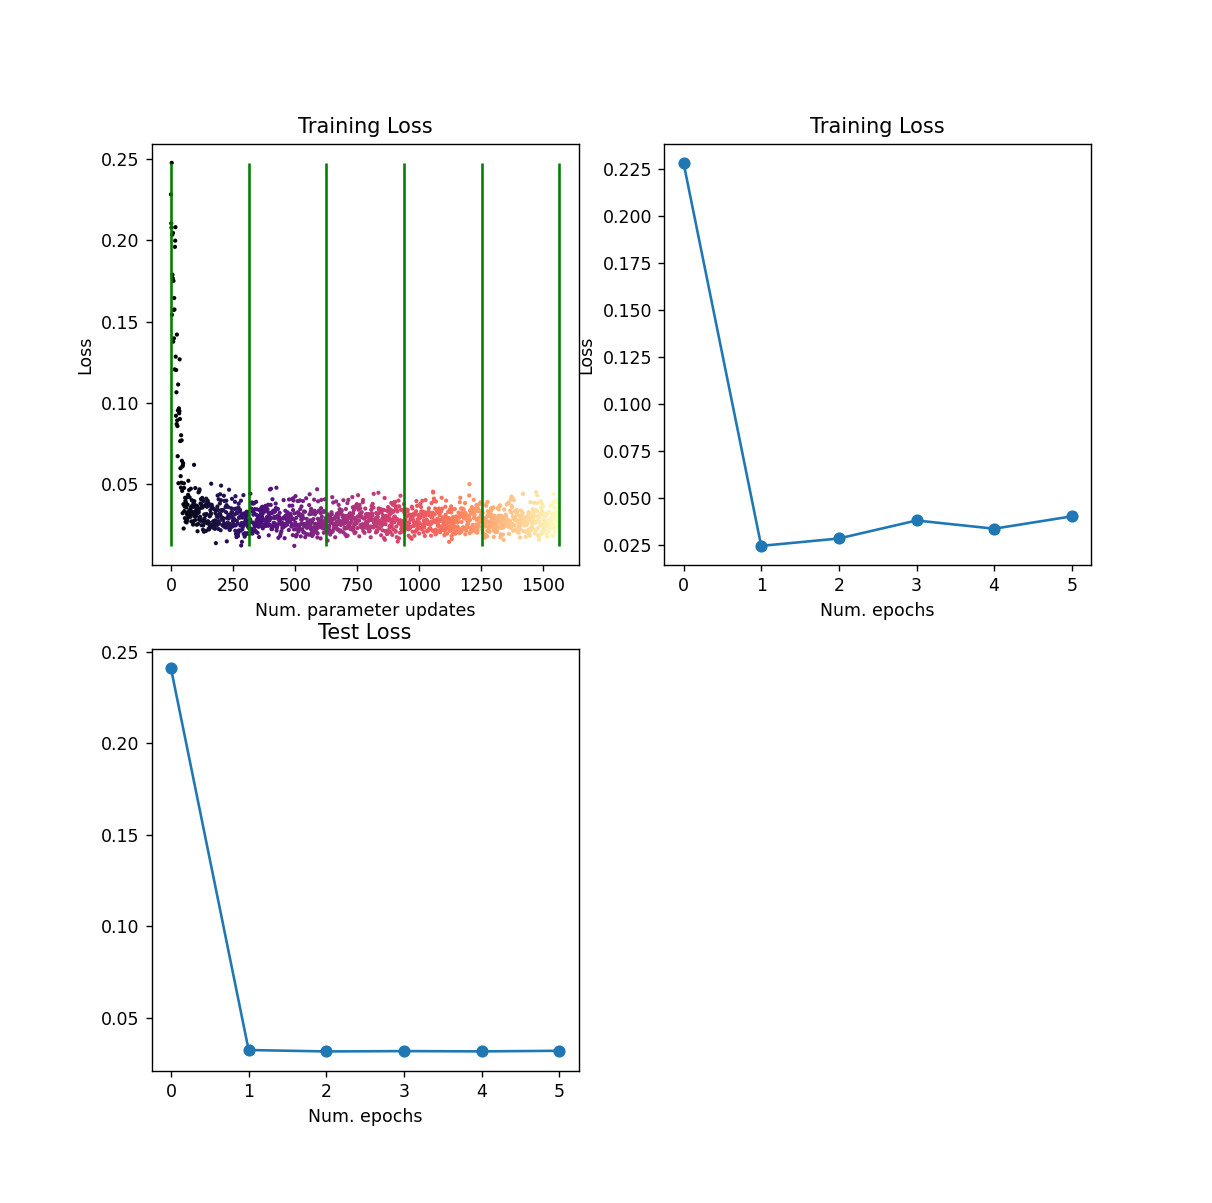

In [10]:
time = np.array([i for i in range(num_param_states)])

plt.figure()
#plotting loss over training
plt.subplot(2, 2, 1)
plt.title('Training Loss')
plt.xlabel('Num. parameter updates')
plt.ylabel('Loss')
plt.scatter(time, train_loss, c=cm.magma(time/(num_param_states-1)), s=2)
plt.vlines(epoch_indices, min(train_loss), max(train_loss), linestyle='solid', colors='g')

plt.subplot(2, 2, 2)
plt.title('Training Loss')
plt.xlabel('Num. epochs')
plt.ylabel('Loss')
plt.plot(train_loss[[int(_) for _ in epoch_indices]], 'o-')

#plotting loss over testing
plt.subplot(2, 2, 3)
plt.title('Test Loss')
plt.xlabel('Num. epochs')
plt.plot(test_loss, 'o-')

# plt.subplot(2, 2, 4)
# plt.title('Test Acc.')
# plt.xlabel('Num. epochs')
# plt.plot(test_acc, 'o-')

In [11]:
"""
List of all available params from training:
    - param_states is np array (num_param_states, num_params) of model states
    - train_loss, test_loss are self explanatory; train_loss is per minibatch
    - epoch_indices is a np arr (num_epochs+1), epoch_indices[i] = param_state idx at end of ith epoch
    - grads, m1s, m2s are np arrays (num_param_states, num_params) of grad, m1, m2 from adam
    - steps is np array (num_param_states-1, num_params) of model steps
""" 

'\nList of all available params from training:\n    - param_states is np array (num_param_states, num_params) of model states\n    - train_loss, test_loss are self explanatory; train_loss is per minibatch\n    - epoch_indices is a np arr (num_epochs+1), epoch_indices[i] = param_state idx at end of ith epoch\n    - grads, m1s, m2s are np arrays (num_param_states, num_params) of grad, m1, m2 from adam\n    - steps is np array (num_param_states-1, num_params) of model steps\n'

In [12]:
from sklearn.decomposition import PCA
print('PCA fitting:')

pca = PCA(n_components=2)
pca.fit(param_states)
#choosing x ax = m, y ax = b
pca.components_ = np.array([[1, 0], [0, 1]])
pca.mean_ = np.array([[0, 0]])
pca_embed = pca.transform(param_states)
print('components_ shape:', pca.components_.shape, '\nsamples shape:', param_states.shape, '\ntransformed shape:', pca_embed.shape)

print("PCA explains", pca.explained_variance_ratio_, '->', sum(pca.explained_variance_ratio_)*100, '% of variance')

PCA fitting:
components_ shape: (2, 2) 
samples shape: (1566, 2) 
transformed shape: (1566, 2)
PCA explains [0.89123486 0.10876514] -> 100.0 % of variance


<IPython.core.display.Javascript object>


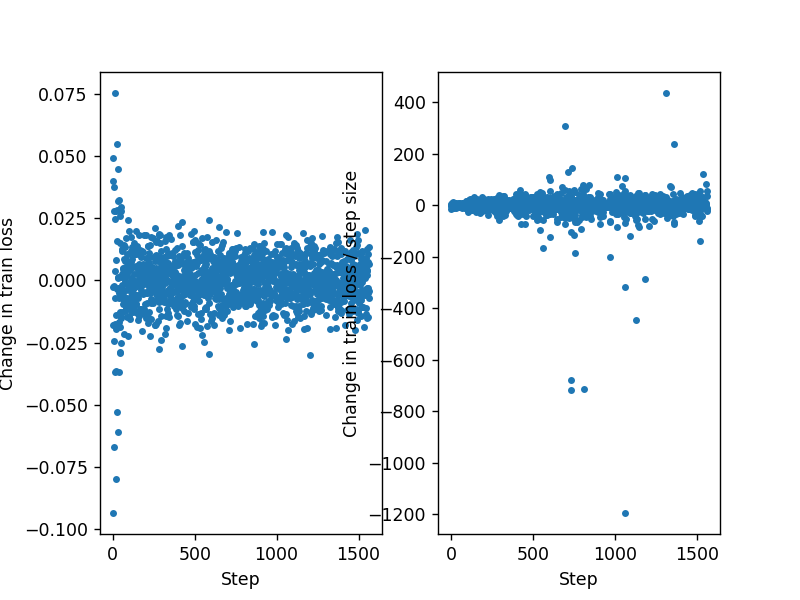

In [13]:
#change in train loss per change in param (effective gradient)
change_train_loss = train_loss[1:] - train_loss[:-1]
plt.figure()
plt.subplot(1, 2, 1)
plt.plot(change_train_loss, '.')
plt.xlabel("Step")
plt.ylabel("Change in train loss")

plt.subplot(1, 2, 2)
plt.plot(change_train_loss/np.linalg.norm(steps, axis=-1), '.')
plt.xlabel("Step")
plt.ylabel("Change in train loss / step size")
plt.show()

Distance travelled in parameter space: 0.5615413200379905


<IPython.core.display.Javascript object>


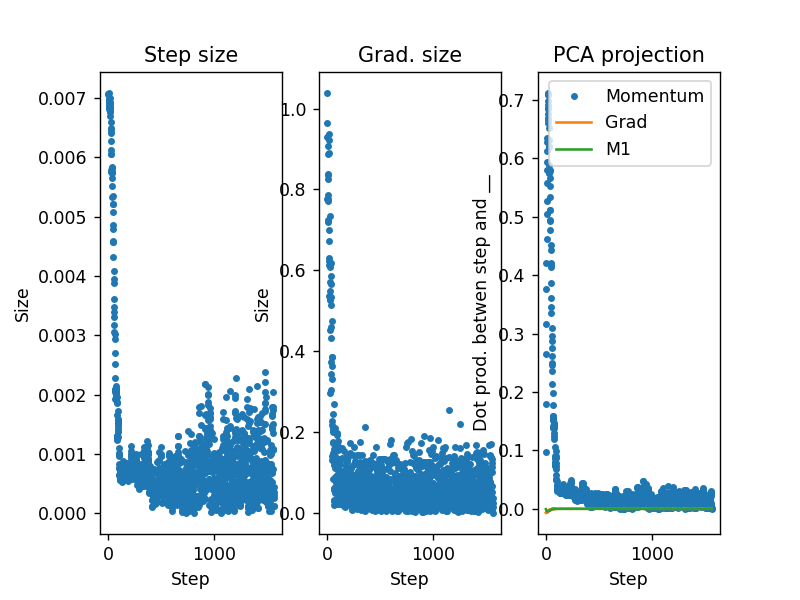

In [14]:
#Looking at properties of the steps the model took

#how far model has learned in param space
learning_length = np.linalg.norm(param_states[-1]-param_states[0])
print('Distance travelled in parameter space:', learning_length)
plt.figure()
plt.subplot(1, 3, 1)
plt.title("Step size")
plt.plot([i+1 for i in range(len(steps))], np.linalg.norm(steps, axis=-1), '.', label='Step')
plt.ylabel('Size')
plt.xlabel("Step")

plt.subplot(1, 3, 2)
plt.title("Grad. size")
plt.plot([i for i in range(len(grads))], np.linalg.norm(grads, axis=-1), '.', label='Grad')
plt.ylabel('Size')
plt.xlabel("Step")

plt.subplot(1, 3, 3)
plt.title("Mom. size")
plt.plot([i for i in range(len(m1s))], np.linalg.norm(m1s, axis=-1), '.', label='Momentum')
plt.ylabel('Size')
plt.xlabel("Step")
plt.legend()

plt.ylabel('Dot prod. betwen step and __')
plt.xlabel("Step")
plt.plot([np.dot(steps[i], grads[i]) for i in range(num_param_states-1)], label='Grad')
plt.plot([np.dot(steps[i], m1s[i]) for i in range(num_param_states-1)], label='M1')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


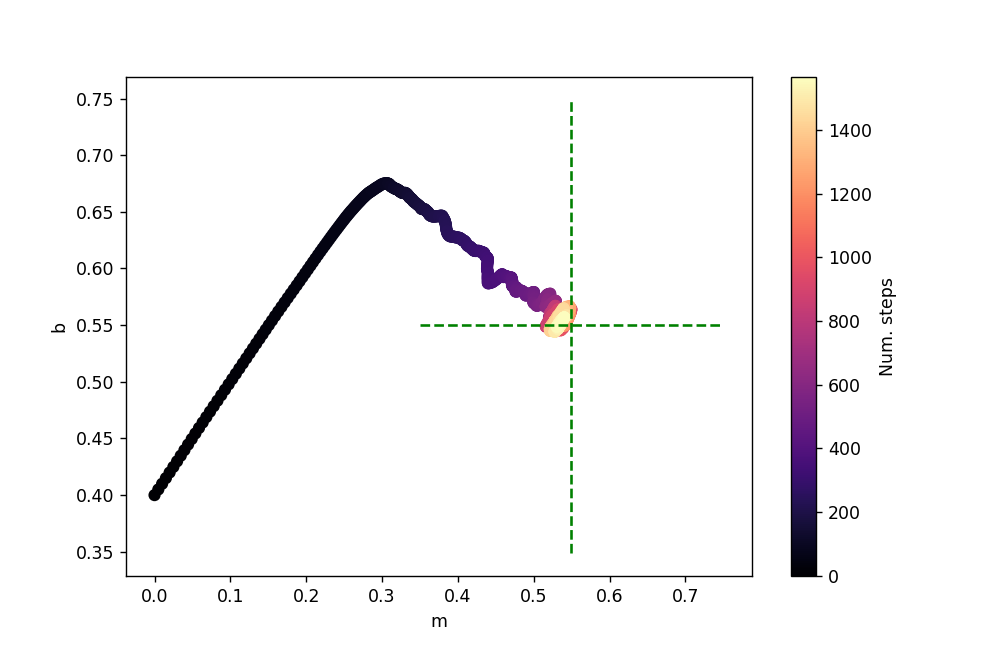

In [25]:
plt.title('PCA projection')
plt.figure()
plt.scatter(pca_embed[:, 0], pca_embed[:,1], c=[val for val in cm.magma(time/(num_param_states-1))])
plt.vlines( [m[0,0]], ymin = m[0,0]-0.2, ymax=m[0,0]+0.2, color='g', linestyle='dashed' )
plt.hlines([b[0]], xmin=b[0]-0.2, xmax=b[0]+0.2, color='g', linestyle='dashed')
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cm.magma), label='Num. steps')
plt.xlabel('m')
plt.ylabel('b')
plt.show()

In [16]:
#the two vectors from PCA, with shape (num_params)
pca_vec1 = pca.components_[0]
pca_vec2 = pca.components_[1]

pca_vec1_path = pca_embed[:, 0]
pca_vec2_path = pca_embed[:,1]

#setting initial model state to origin of PCA plot
# orig_idx = 0
# origin = param_states[orig_idx]

# pca_vec1_path = pca_vec1_path - pca_vec1_path[orig_idx]*np.ones_like(pca_vec1_path)
# pca_vec2_path = pca_vec2_path - pca_vec2_path[orig_idx]*np.ones_like(pca_vec2_path)

#if you want to set the coordinate axes to the true values
pca.mean_ = np.zeros_like(pca.mean_)
origin = np.zeros((2))

#applying PCA to gradients and m1s from Adam
pca.mean_ = np.zeros_like(pca.mean_)
grads_embed = pca.transform(grads)
m1s_embed = pca.transform(m1s)

<IPython.core.display.Javascript object>


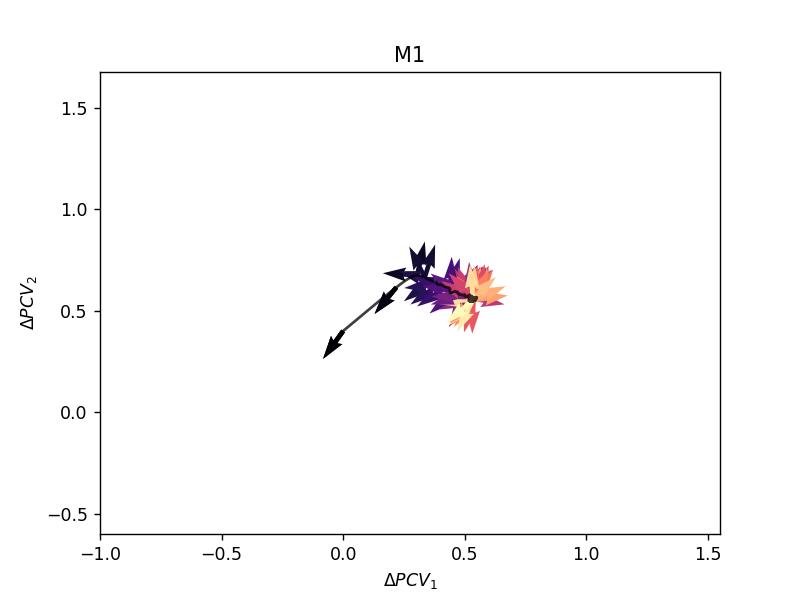

In [17]:
#can adjust pad to zoom in or out
pad = 1
resolution = 50

plt.figure()
plt.plot(pca_vec1_path, pca_vec2_path, c='k', alpha=0.5)

plt.xlim((min(pca_vec1_path)-pad, max(pca_vec1_path)+pad))
plt.ylim((min(pca_vec2_path)-pad, max(pca_vec2_path)+pad))
plt.title("Gradient")
plt.xlabel('$\Delta PCV_{1}$')
plt.ylabel('$\Delta PCV_{2}$')
for t in range(0, num_param_states-1, resolution):
    plt.quiver(pca_vec1_path[t], pca_vec2_path[t], grads_embed[t,0], grads_embed[t,1], color=cm.magma(t/(num_param_states-1)), angles='xy')

plt.xlim((min(pca_vec1_path)-pad, max(pca_vec1_path)+pad))
plt.ylim((min(pca_vec2_path)-pad, max(pca_vec2_path)+pad))
plt.title("M1")
plt.xlabel('$\Delta PCV_{1}$')
plt.ylabel('$\Delta PCV_{2}$')
#plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap))
plt.plot(pca_vec1_path, pca_vec2_path, c='k', alpha=0.5)
for t in range(0, num_param_states-1, resolution):
    plt.quiver(pca_vec1_path[t], pca_vec2_path[t], m1s_embed[t,0], m1s_embed[t,1], color=cm.magma(t/(num_param_states-1)), angles='xy')
plt.show()

In [26]:
#calculating loss landscape
from mpl_toolkits.mplot3d import Axes3D

def loss_at(param_state):
    state = vector_to_state_dict(param_state, model)

    model.load_state_dict(state)
    

    this_loss = test(train_data, model, loss_fn)
    return this_loss

def calc_loss_grid(lb1, ub1, lb2, ub2, origin=origin, v1_bins=20, v2_bins=20, filename=r'loss_grid'):
    #data in scatter form (m, b, Loss)
    #loss_grid = np.zeros((100, 100))
    info = np.array([lb1, ub1, lb2, ub2, v1_bins, v2_bins])

    range1 = np.linspace(lb1, ub1, v1_bins)
    range2 = np.linspace(lb2, ub2, v2_bins)

    pnts1 = np.zeros((range1.size*range2.size))
    pnts2 = np.zeros((range1.size*range2.size))
    loss_pnts = np.zeros((range1.size*range2.size))

    idx = 0
    for v1 in range1:
        for v2 in range2:
            if idx != 0 and idx % 10==0:
                print(idx, '/', len(loss_pnts))
            #print(idx, "/", len(b_pnts))
            pnts1[idx] = v1
            pnts2[idx] = v2
            #print(origin.shape, pca_vec1.shape, pca_vec2.shape)
            loss_pnts[idx] = loss_at(origin + v1*pca_vec1 + v2*pca_vec2)
            idx += 1

#     with open(filename + '.npz', 'wb') as file:
#         np.savez(file, info=info, v1_pnts=pnts1, v2_pnts=pnts2, loss_pnts=loss_pnts)
        
    return pnts1, pnts2, loss_pnts




minimum = min(list(pca_vec1_path) + list(pca_vec2_path))
maximum = max(list(pca_vec1_path) + list(pca_vec2_path))
pad = 1.5*(maximum-minimum)
lb1 = np.mean(pca_vec1_path) - pad
ub1 = np.mean(pca_vec1_path) + pad
lb2 = np.mean(pca_vec2_path) - pad
ub2 = np.mean(pca_vec2_path) + pad

# sets number of bins; more bins = more resolution = more comp. time
v1_bins = 20
v2_bins = 20

v1_pnts, v2_pnts, loss_pnts = calc_loss_grid(lb1, ub1, lb2, ub2, v1_bins=v1_bins, v2_bins=v2_bins)

10 / 400
20 / 400
30 / 400
40 / 400
50 / 400
60 / 400
70 / 400
80 / 400
90 / 400
100 / 400
110 / 400
120 / 400
130 / 400
140 / 400
150 / 400
160 / 400
170 / 400
180 / 400
190 / 400
200 / 400
210 / 400
220 / 400
230 / 400
240 / 400
250 / 400
260 / 400
270 / 400
280 / 400
290 / 400
300 / 400
310 / 400
320 / 400
330 / 400
340 / 400
350 / 400
360 / 400
370 / 400
380 / 400
390 / 400


<IPython.core.display.Javascript object>


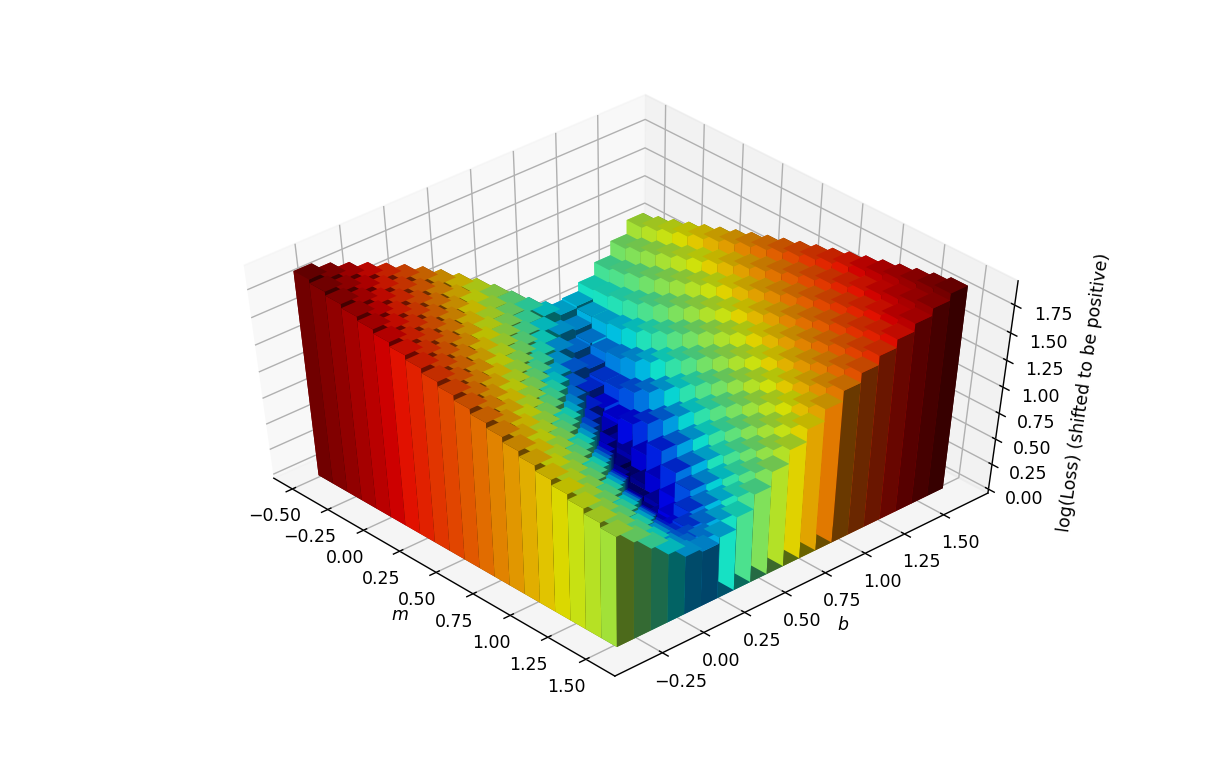

In [29]:
def bar_plot_3d(v1_pnts, v2_pnts, loss_pnts, tuple):

    fig = plt.figure()          #create a canvas, tell matplotlib it's 3d
    ax = fig.add_subplot(111, projection='3d')

    #make histogram stuff - set bins - I choose 20x20 because I have a lot of data
    hist, xedges, yedges = np.histogram2d(v2_pnts, v1_pnts, bins=tuple)
    xpos, ypos = np.meshgrid(xedges[:-1]+xedges[1:], yedges[:-1]+yedges[1:])

    #print(xpos)
    xpos = xpos.flatten()/2.
    ypos = ypos.flatten()/2.
    #print(xpos)
    zpos = np.zeros_like(xpos)
    dx = xedges [1] - xedges [0]
    dy = yedges [1] - yedges [0]
    dz = np.log10(loss_pnts) + np.abs(min(np.log10(loss_pnts)))*np.ones_like(loss_pnts)
    #dz = loss_pnts

    #dz[np.argmin(dz)] = 10


    cmap = cm.get_cmap('jet') # Get desired colormap - you can change this!
    max_height = np.max(dz)   # get range of colorbars so we can normalize
    min_height = np.min(dz)
    # scale each z to [0,1], and get their rgb values
    rgba = [cmap((k-min_height)/(max_height-min_height)) for k in dz]

    ax.bar3d(ypos, xpos, zpos, dx, dy, dz, color=rgba, zsort='average')
    #plt.title("Loss LEGO plot")
    plt.xlabel("$m$")
    plt.ylabel("$b$")
    #ax.set_zlabel('Loss')
    ax.set_zlabel('log(Loss) (shifted to be positive)')
    #ax.zaxis.set_scale('log')
    #plt.show()
    return

# with open('loss_grid.npz', 'rb') as f:
#     npzfile = np.load(f)
#     info = npzfile['info']
#     v1_pnts = npzfile['v1_pnts']
#     v2_pnts = npzfile['v2_pnts']
#     loss_pnts = npzfile['loss_pnts']
# lb1 = info[0]
# ub1 = info[1]
# lb2 = info[2]
# ub2 = info[3]
# v1_bins = int(info[4])
# v2_bins = int(info[5])

bar_plot_3d(v1_pnts, v2_pnts, loss_pnts, (int(v1_bins),int(v2_bins)))
plt.show()

<IPython.core.display.Javascript object>


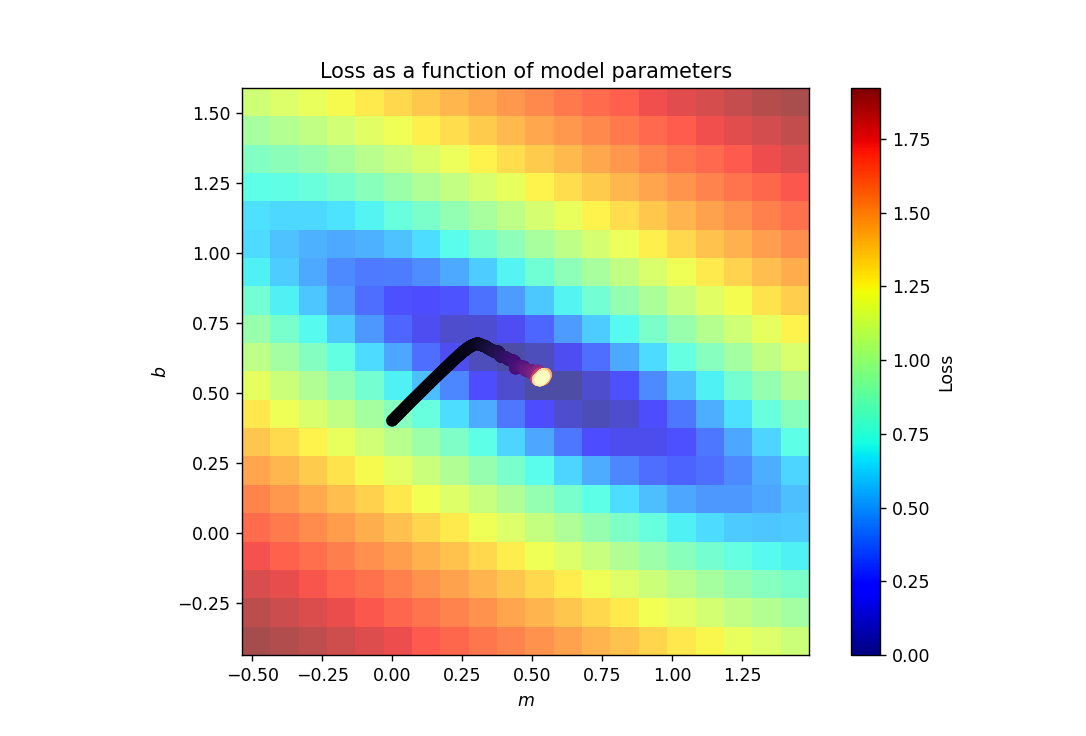

(-0.4376190324167639, 1.5881085972447961)

In [30]:
#log scaling if wanted
loss_pnts = np.log10(loss_pnts) + np.abs(min(np.log10(loss_pnts)))*np.ones_like(loss_pnts)

low = min(loss_pnts)
high = max(loss_pnts)
#rescaling elements of loss_pnts
loss_pnts_scaled = (loss_pnts - low*np.ones_like(loss_pnts))/(high-low)

cmap1 = cm.plasma
norm1 = colors.Normalize(vmin=min(loss_pnts), vmax=max(loss_pnts))
plt.figure()
plt.colorbar(cm.ScalarMappable(norm=norm1, cmap=cm.jet), label='Loss')
im_loss = loss_pnts.reshape(v1_bins,v2_bins)

cmap = cm.viridis
norm1 = colors.Normalize(vmin=0, vmax=len(pca_vec1_path))

plt.imshow(np.flip(im_loss.T, axis=0), extent=[lb1,ub1,lb2,ub2], cmap=cm.jet, alpha=0.7)
plt.scatter(pca_vec1_path, pca_vec2_path, c=[cm.magma(i/len(pca_vec1_path)) for i in range(len(pca_vec1_path))], alpha=1, zorder=1)
#plt.scatter([250], [250], c=[(0,1,0)])
# plt.xlabel('$\Delta PCV_{1}$')
# plt.ylabel('$\Delta PCV_{2}$')
plt.title('Loss as a function of model parameters')
plt.xlabel('$m$')
plt.ylabel('$b$')
plt.xlim(lb1, ub1)
plt.ylim(lb2, ub2)

In [21]:
y_pred = np.zeros((num_param_states, num_test))
for i in range(num_param_states):
    
    if i % 100 == 0:
        print(i, '/', num_param_states)
    
    this_m = param_states[i,0]
    this_b = param_states[i,1]
    
    y_pred[i] = this_m*x + this_b

0 / 1566
100 / 1566
200 / 1566
300 / 1566
400 / 1566
500 / 1566
600 / 1566
700 / 1566
800 / 1566
900 / 1566
1000 / 1566
1100 / 1566
1200 / 1566
1300 / 1566
1400 / 1566
1500 / 1566


<IPython.core.display.Javascript object>


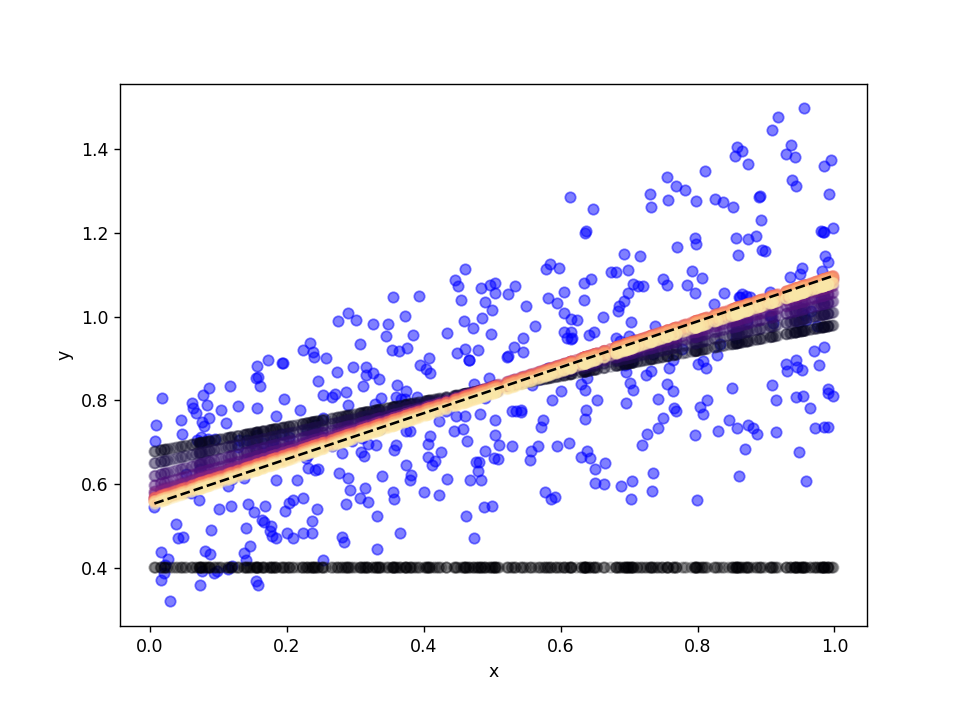

final params: [0.53935975 0.5562681 ]
actual params: 0.5488135039273248 0.5497055616691202


In [28]:
plt.figure()
plt.scatter(x, y, c='b', alpha=0.5)
plt.plot(axis, [m[0,0]*val + b[0] for val in axis], 'k--')
for i in np.arange(0, num_param_states, 100):
    plt.scatter(x, y_pred[i], c=[cm.magma(i/(num_param_states-1)) for val in x], alpha=0.2)
#plt.title("Model predictions over training")
plt.xlabel('x')
plt.ylabel('y')

print('final params:', param_states[-1])
print('actual params:', m[0,0], b[0])

#plt.colorbar(cm.ScalarMappable(cmap=cm.magma, norm=norm))